In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
env = gym.make("FrozenLake-v1",is_slippery = False)
initial_state = env.reset()
print("Environment initialized.")
print("Initial State:", initial_state)

Environment initialized.
Initial State: (0, {'prob': 1})


In [3]:
# State and action space
print("Number of states:", env.observation_space.n)
print("Number of actions:", env.action_space.n)

# Optional: Display what the actions mean
actions = {
    0: "Left",
    1: "Down",
    2: "Right",
    3: "Up"
}
print("Actions mapping:", actions)

Number of states: 16
Number of actions: 4
Actions mapping: {0: 'Left', 1: 'Down', 2: 'Right', 3: 'Up'}


In [4]:
print(env.desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [5]:
state = env.reset()
done = False
total_reward = 0

while not done:
    action = env.action_space.sample()
    new_state, reward, done, _, _ = env.step(action)
    total_reward += reward

print("Sample episode reward:", total_reward)

Sample episode reward: 0.0


In [6]:
state_size = env.observation_space.n
action_size = env.action_space.n
Q_table = np.zeros((state_size, action_size))
print("Q-table shape:", Q_table.shape)
print("Initial Q-table:\n", Q_table)

Q-table shape: (16, 4)
Initial Q-table:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [7]:
learning_rate = 0.8
discount_factor = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 1000
max_steps = 100

## Reinforcement Learning Hyperparameters

| Hyperparameter | Symbol | Meaning |
|---------------|--------|---------|
| `learning_rate` | α | How much new Q-values override the old ones (0 = no learning, 1 = overwrite completely) |
| `discount_factor` | γ | How much future rewards are considered important compared to immediate rewards |
| `epsilon` | ε | Controls **exploration** vs **exploitation** — the higher it is, the more the agent tries random actions |
| `epsilon_min` | — | Lower bound for exploration (so agent never stops exploring completely) |
| `epsilon_decay` | — | Controls how fast ε decreases (from 1 to `epsilon_min`) to shift from exploration to exploitation |
| `episodes` | — | Number of times the agent trains from scratch (restarts the environment) |
| `max_steps` | — | To prevent the agent from running forever in a single episode |

In [8]:
def choose_action(state,epsilon):
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

In [9]:
rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = choose_action(state, epsilon)
        new_state, reward, done, truncated, _ = env.step(action)

        best_next_action = np.max(Q_table[new_state])
        Q_table[state, action] += learning_rate * (reward + discount_factor * best_next_action - Q_table[state, action])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon:.4f}")


Episode 100: Total Reward = 0.0, Epsilon = 0.6058
Episode 200: Total Reward = 0.0, Epsilon = 0.3670
Episode 300: Total Reward = 0.0, Epsilon = 0.2223
Episode 400: Total Reward = 1.0, Epsilon = 0.1347
Episode 500: Total Reward = 1.0, Epsilon = 0.0816
Episode 600: Total Reward = 1.0, Epsilon = 0.0494
Episode 700: Total Reward = 1.0, Epsilon = 0.0299
Episode 800: Total Reward = 1.0, Epsilon = 0.0181
Episode 900: Total Reward = 1.0, Epsilon = 0.0110
Episode 1000: Total Reward = 1.0, Epsilon = 0.0100


## Q-Learning Formula Recap:

$$Q(s,a) = Q(s,a) + \alpha \left[ r + \gamma \cdot \max_a Q(s', a) - Q(s, a) \right]$$

Where:
* **s**: current state
* **a**: action taken
* **r**: reward received
* **s'**: new state after action
* **α**: learning rate
* **γ**: discount factor

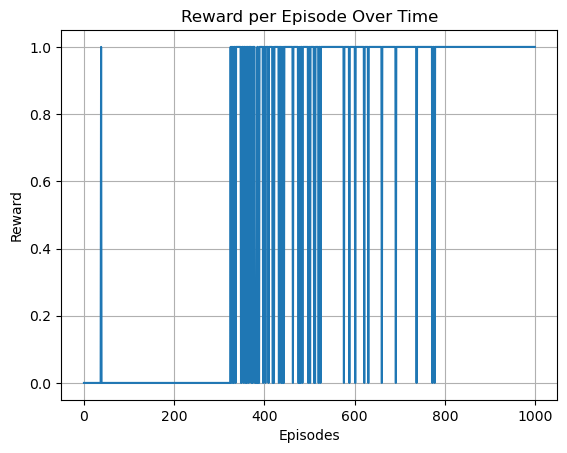

In [10]:
plt.plot(range(episodes), rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward per Episode Over Time')
plt.grid(True)
plt.show()

In [11]:
test_episodes = 100
successes = 0

for episode in range(test_episodes):
    state = env.reset()[0]  # Get initial state
    done = False

    while not done:
        action = np.argmax(Q_table[state])
        
        new_state, reward, done, truncated, info = env.step(action)
        state = new_state

        if done and reward == 1.0:
            successes += 1

success_rate = successes / test_episodes
print(f"Success rate over {test_episodes} test episodes: {success_rate:.2f}")

Success rate over 100 test episodes: 1.00


In [12]:
def train_agent(epsilon_strategy='fixed', num_episodes=1000):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    epsilon = 1.0

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0

        for _ in range(100):
            if epsilon_strategy == 'fixed':
                eps = 0.1
            elif epsilon_strategy == 'decay':
                eps = max(0.01, 1 - (episode / num_episodes))
            elif epsilon_strategy == 'min_decay':
                eps = max(0.01, epsilon * 0.99)
            else:
                eps = 0.1

            if random.uniform(0, 1) < eps:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            new_state, reward, done, truncated, _ = env.step(action)

            best_next = np.max(Q[new_state])
            Q[state, action] += learning_rate * (reward + discount_factor * best_next - Q[state, action])
            state = new_state
            total_reward += reward

            if done:
                break

        if epsilon_strategy == 'min_decay':
            epsilon *= 0.99

        rewards.append(total_reward)

    return Q, rewards


In [14]:
import random
strategies = ['fixed', 'decay', 'min_decay']
all_rewards = {}

for strategy in strategies:
    print(f"\nTraining with strategy: {strategy}")
    _, rewards = train_agent(epsilon_strategy=strategy)
    all_rewards[strategy] = rewards



Training with strategy: fixed

Training with strategy: decay

Training with strategy: min_decay


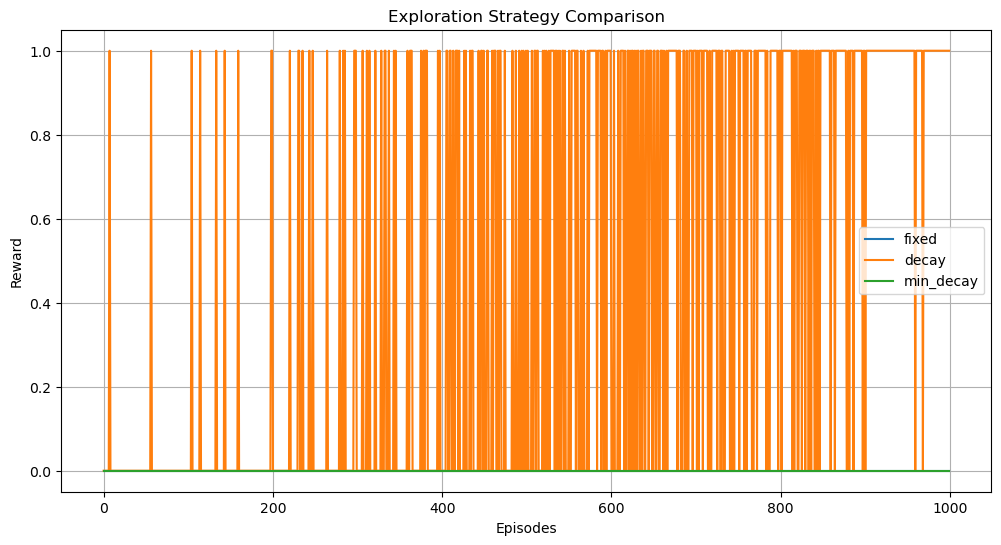

In [15]:
plt.figure(figsize=(12, 6))
for strategy in strategies:
    plt.plot(all_rewards[strategy], label=strategy)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Exploration Strategy Comparison')
plt.legend()
plt.grid()
plt.show()

## Strategy Comparison Analysis

`fixed`:
* This line is hard to distinguish, possibly overlapping with others.
* Suggests the agent **learned poorly** or inconsistently with constant exploration.

`decay`:
* Achieved **more frequent rewards** over time.
* Shows that **gradually reducing exploration** helped the agent shift from exploration to exploitation, improving performance.

`min_decay`:
* Remains near 0 across all episodes.
* Suggests the agent **did not learn** well — possibly because it **kept exploring too much** or the decay rate/minimum ε wasn't effective.

**Insights**
* The `decay` strategy performs best, allowing the agent to:
  * Explore effectively early on,
  * Focus on exploiting good actions later.
* The `min_decay` might need tuning (e.g., slower decay, better minimum ε).
* The `fixed` ε strategy might work better with different ε values (e.g., 0.3 or 0.5).